# MS gate - qutip simulation

Gate between two optical qubits, implemented in the $S_{1/2} \to D_{5/2}$ transition in $^{40}\text{Ca}^+$ ions

In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, destroy, qeye, sigmay, basis, mesolve, sigmaz, sigmax, Options, sigmap, sigmam, thermal_dm


In [2]:
A = tensor(sigmax(), qeye(2))
B = tensor(qeye(2), sigmax())

A * B

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [8]:
sigmaz()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [9]:
basis(2, 0)

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

In [5]:
B

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [3]:
tensor(sigmax(), sigmax())

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [2]:
import qutip
qutip.rhs_clear()
from tqdm import tqdm

In [10]:
def sigma_phi(phi):
    return np.exp(1j * phi) * sigmap() + np.exp(-1j * phi) * sigmam()

In [3]:
from scipy.constants import kilo, mega, micro, nano, hbar, pi, atomic_mass

to_khz = 1e3

kHz = kilo
MHz = mega
us = micro
mass = 40 * atomic_mass


In [31]:
v, a = sigmax().eigenstates()

In [36]:
import qutip

In [41]:
isinstance(sigmax(), qutip.Qobj)

True

In [35]:
a[0]

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.70710678]
 [ 0.70710678]]

In [26]:
param_names = dict(Omega="Omega1", Delta="Delta", gamma="gamma")
"{Omega} = {Omega} * 2 * pi * 3".format(**param_names)

'Omega1 = Omega1 * 2 * pi * 3'

In [16]:
def sigma_op_j(sigma_op, j, N_ions):
    """Returns the operator sigma_op acting on the j-th ion in a chain of N_ions ions."""
    ops = [qeye(2) for _ in range(N_ions)]
    ops[j] = sigma_op
    return tensor(*ops)

In [4]:
def sigma_op_j(sigma_op, n, j):
    ops = [qeye(2) for _ in range(n)]
    ops[j] = sigma_op
    return tensor(*ops)

n_ions = 2
sigma_zs = [sigma_op_j(sigmaz(), n_ions, j) for j in range(n_ions)]
# sigma_op_j(sigmaz(), 2, 1)
# tensor(sigmaz(), qeye(2))

In [5]:
g = basis(2, 0)
e = basis(2, 1)

gg = g * g.dag()
ee = e * e.dag()

U = (-1j * pi / 4 * sigmay()).expm()

gx = U * gg * U.dag()
ge = U * ee * U.dag()

px = (g + e).unit()
pxx = px * px.dag()


In [82]:

class Solver:

    def __init__(self, n_max=20, 
            trap_freq=1.84, delta_ss_ptp=0.3):

        # All frequencies in MHz, all times in us

        self._id = id(self)
        self.rhs_name = f"cqobjevo_ls_{self._id}"

        nu = 2 * pi * trap_freq

        lambd = 729 * nano
        k = 2 * pi / lambd
        q = k * np.sin(np.deg2rad(37))
        a_ho = np.sqrt(hbar / 2 / mass / (nu * mega))

        eta = k * a_ho
        zeta = q * a_ho

        self.n_max = n_max
        self.default_args = {
            'Delta': pi * delta_ss_ptp,
            'nu': nu,
            'delta': 0,
            'phi': 0
        }

        a = destroy(n_max)
        a_dag = a.dag()
        id_s = qeye(2)
        id_m = qeye(n_max)

        n_ions = 2
        sigma_zs = [sigma_op_j(sigmaz(), n_ions, j) for j in range(n_ions)]
        Sz = sum(sigma_zs)

        H_ss = [
            [zeta * tensor(Sz, a), 'Delta * exp(-1j * nu * t) * cos((nu + 2 * pi * delta) * t + phi)'],
            [zeta * tensor(Sz, a_dag), 'Delta * exp(1j * nu * t) * cos((nu + 2 * pi * delta) * t + phi)']
        ]

        # RWA
        # H_ss = [
        #     [zeta * tensor(Sz, a), 'Delta * exp(-1j * (phi + 2 * pi * delta * t))'],
        #     [zeta * tensor(Sz, a_dag), 'Delta * exp(1j * (phi + 2 * pi * delta * t))']
        # ]

        self.H = H_ss
        # H = H_car + H_rsb + H_bsb
        # H = H_car

        g = basis(2, 0)
        gg = g * g.dag()
        e = basis(2, 1)
        ee = e * e.dag()

        gx = sigmax() * gg * sigmax()
        ex = sigmax() * ee * sigmax()

        U = (-1j * pi / 4 * sigmay()).expm()

        gx = U * gg * U.dag()  # project on (g + e)
        ex = U * ee * U.dag()  # project on (g - e)

        p2 = tensor(gg, gg)
        p1 = tensor(gg, ee) + tensor(ee, gg)
        p0 = tensor(ee, ee)

        p2x = tensor(gx, gx)
        p1x = tensor(gx, ex) + tensor(ex, gx)
        p0x = tensor(ex, ex)

        bell_state0 = (tensor(g, g) + tensor(e, e)).unit()
        bell_state1 = (tensor(g, g) - tensor(e, e)).unit()
        bell_state2 = (tensor(g, e) + tensor(e, g)).unit()
        bell_state3 = (tensor(g, e) - tensor(e, g)).unit()

        self.e_ops = {
            'p2': tensor(p2, id_m),
            'p1': tensor(p1, id_m),
            'p0': tensor(p0, id_m),
            'p2x': tensor(p2x, id_m),
            'p1x': tensor(p1x, id_m),
            'p0x': tensor(p0x, id_m),
            'bell_state0': tensor(bell_state0 * bell_state0.dag(), id_m),
            'bell_state1': tensor(bell_state1 * bell_state1.dag(), id_m),
            'bell_state2': tensor(bell_state2 * bell_state2.dag(), id_m),
            'bell_state3': tensor(bell_state3 * bell_state3.dag(), id_m),
            'x': tensor(id_s, id_s, a + a_dag),
            'p': tensor(id_s, id_s, 1j * (a_dag  - a)),
            'n': tensor(id_s, id_s, a_dag * a),
            'x1g': tensor(gg, id_s, a + a_dag),
            'p1g': tensor(gg, id_s, 1j * (a_dag - a)),
            'x1e': tensor(ee, id_s, a + a_dag),
            'p1e': tensor(ee, id_s, 1j * (a_dag - a)),
        }

        self.options = Options()
        # self.options.nsteps = 1e4
        # self.options.max_step = max_step
        self.options.rhs_with_state = True
        self.options.rhs_reuse = True
        self.options.rhs_filename = self.rhs_name

        # qutip.rhs_generate(self.H, c_ops=[], args=self.default_args, name=self.rhs_name)

    def make_psi0(self, s0, n0, nbar):
        if nbar is not None:
            psi_m = thermal_dm(self.n_max, nbar)
        else:
            psi_m = basis(self.n_max, n0) * basis(self.n_max, n0).dag()
        if s0 == 'z':
            psi_s = basis(2, 0) * basis(2, 0).dag()
        elif s0 == 'x':
            px = (basis(2, 0) + basis(2, 1)).unit()
            psi_s = px * px.dag()
        return tensor(psi_s, psi_s, psi_m)


    def run_t(self, t, s0='z', n0=0, nbar=None, args={}, **kwargs):
        psi0 = self.make_psi0(s0, n0, nbar)
        _args = self.default_args.copy()
        _args.update(args)
        result = mesolve(self.H, psi0, t, c_ops=None, e_ops=self.e_ops,
                         args=_args, options=self.options, **kwargs)
        return result

    # def run_delta(self, delta, n0=0, nbar=None, t=None, dt=10, args={}):
    #     t = np.arange(0, self.pi_time + dt, dt) if t is None else t
    #     p_g = np.zeros_like(delta)

    #     for j, _delta in enumerate(tqdm(delta)):
    #         args = {'delta': _delta}
    #         _p_g = self.run_t(t, n0, nbar, args)
    #         p_g[j] = _p_g[-1]

    #     return p_g

    # def _parallel_task(self, delta, t, n0, nbar):
    #     return self.run_t(t, n0, nbar, args={'delta': delta})[-1]


    # def _run_delta_par(self, delta, n0=0, nbar=None, t=None, dt=10, args={}):
    #     t = np.arange(0, self.pi_time + dt, dt) if t is None else t


    #     p_g = qutip.parallel.parallel_map(self._parallel_task, delta, task_args=(t, n0, nbar), progress_bar=True)
    #     return np.asarray(p_g)


In [88]:
qutip.rhs_clear()

In [89]:
# %%timeit -r 1 -n 1

n_max = 30
pi_time = 200
trap_freq = 1.3

nu = 2 * pi * trap_freq

lambd = 729 * nano
k = 2 * pi / lambd
q = k * np.sin(np.deg2rad(37))
a_ho = np.sqrt(hbar / 2 / mass / (nu * mega))

eta = k * a_ho
zeta = eta * np.sin(np.deg2rad(37))
delta_ss_ptp = 0.3
f_force = zeta * delta_ss_ptp / 2

# delta_nu_khz = q**2 * hbar * Delta_ss_ptp_khz / 2 / mass / (2 * pi * trap_freq * mega)

sol = Solver(trap_freq=trap_freq, delta_ss_ptp=delta_ss_ptp, n_max=n_max)


2.0
15.340642443268171
130.37263643920247


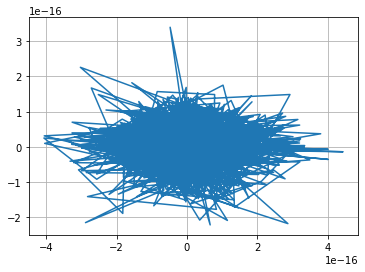

In [94]:

dt = 0.05
# t1 = 100

n_loops = 2
phase_pi = 1
m = 2 * np.sqrt(n_loops / phase_pi / 2)
print(m)
print(delta * to_khz)

delta = m * f_force
t1 = n_loops / delta
print(t1)
t = np.linspace(0, t1, int(t1 / dt))
res = sol.run_t(t, s0='x', n0=0, args={'delta': delta}, progress_bar=None)
# res2 = sol2.run_t(t, s0='z', n0=0, args={'delta': delta}, progress_bar=None)
plt.plot(res.expect['x'], res.expect['p'])

plt.gca().set_aspect(1)
plt.grid()


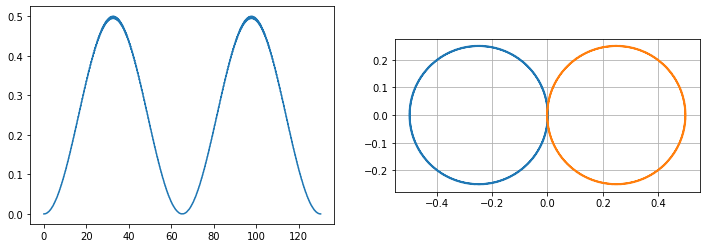

In [91]:
fig, (ax, axx) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(t, res.expect['n'])


# plt.plot(t, res.expect['pxx'])
# plt.figure(figsize=(5, 5))
axx.plot(res.expect['x1g'], res.expect['p1g'])
axx.plot(res.expect['x1e'], res.expect['p1e'])
# plt.gca().set_aspect(1)
# plt.grid()

# plt.plot(res2.expect['x1gg'], res2.expect['p1gg'])
# plt.plot(res2.expect['x1ge'], res2.expect['p1ge'])

# # plt.plot(res2.expect['x1g'], res2.expect['p1g'])
# plt.plot(res2.expect['x1e'], res2.expect['p1e'])


axx.set_aspect(1)
axx.grid()


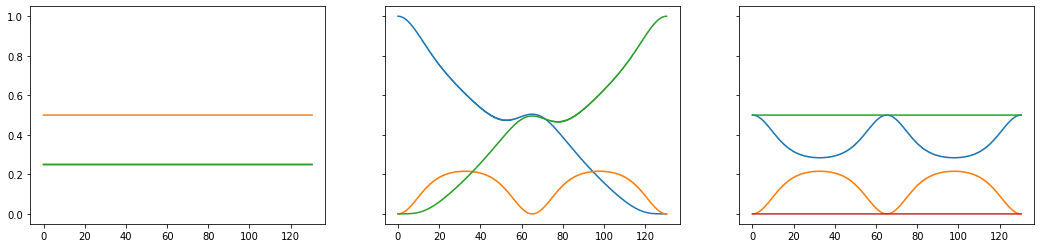

In [92]:
fig, (ax, axx, ax2) = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

ax.plot(t, res.expect['p2'])
ax.plot(t, res.expect['p1'])
ax.plot(t, res.expect['p0'])

# plt.plot(t, res.expect['pxx'])

axx.plot(t, res.expect['p2x'])
axx.plot(t, res.expect['p1x'])
axx.plot(t, res.expect['p0x'])

ax2.plot(t, res.expect['bell_state0'])
ax2.plot(t, res.expect['bell_state1'])
ax2.plot(t, res.expect['bell_state2'])
ax2.plot(t, res.expect['bell_state3'])


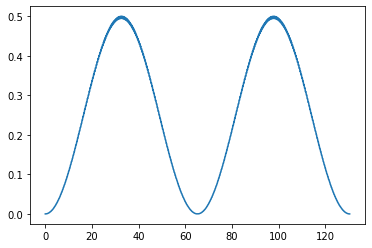

In [93]:
plt.plot(t, res.expect['n'])

In [51]:
for k in 0, 1, 2, 4, 6, 10, 20:
    # for k in [0]:
    print(k)
    delta = k * f_force
    res = sol.run_t(t, s0='z', n0=0, args={'delta': delta}, progress_bar=None)
    plt.plot(res.expect['x'], res.expect['p'])
# plt.ylim(-0.05, 1.05)
plt.gca().set_aspect(1)
plt.grid()


0


KeyboardInterrupt: 

In [12]:
0.5 / f_force

77.55212238711506

In [ ]:
plt.plot(t, p.expect['p2'])

plt.ylim(-0.05, 1.05)


In [ ]:
plt.plot(p.expect['x'], p.expect['p'])

# plt.ylim(-0.05, 1.05)


In [ ]:
delta = np.linspace(-20, 20, 51) * 1e-3

# dt = 10
# t = np.arange(0, 1000 + dt, dt)
p_g0 = sol.run_delta(delta, dt=10)
plt.plot(delta * to_khz, p_g0)

p_g = sol2.run_delta(delta, dt=10)
plt.plot(delta * to_khz, p_g)


In [ ]:
delta = np.linspace(-20, 20, 51) * 1e-3

nbar = 2.5
plt.plot(delta * to_khz, p_g0, 'k')


p_g = sol2.run_delta(delta, n0=0, dt=20)
plt.plot(delta * to_khz, p_g)

p_g = sol2.run_delta(delta, n0=1, dt=20)
plt.plot(delta * to_khz, p_g)

p_g = sol2.run_delta(delta, nbar=nbar, dt=20)
plt.plot(delta * to_khz, p_g)


In [ ]:
delta = np.linspace(-2, 20, 81) * 1e-3 + trap_freq

nbar = 2.5
# plt.plot(delta * to_khz, p_g0, 'k')

dt = 100
sb_pi_time = sol.pi_time / eta
t = np.linspace(0, sb_pi_time, int(round(sb_pi_time / dt)))

p_g = sol2.run_delta(delta, n0=0, t=t)
plt.plot(delta * to_khz, p_g)

p_g = sol2.run_delta(delta, n0=1, t=t)
plt.plot(delta * to_khz, p_g)

p_g = sol2.run_delta(delta, nbar=nbar, t=t)
plt.plot(delta * to_khz, p_g)


In [ ]:
# n_max = 10
# pi_time = 2
# trap_freq = 1.84

# sol0 = Solver(trap_freq=trap_freq, pi_time=pi_time, delta_ss_ptp=0, n_max=n_max)


# rabi_freq = 0.5 / pi_time
# delta = trap_freq

dt = 200
sb_pi_time = sol.pi_time / eta
t = np.linspace(0, sb_pi_time, int(round(sb_pi_time / dt)))
p = sol.run_t(t, n0=0, args={'delta': trap_freq})
plt.plot(t, p)


In [ ]:
eta

In [ ]:

# H = [
#     [sigmap(), 'Omega * exp(1j * delta * t)'],
#     [sigmam(), 'Omega * exp(-1j * delta * t)']
# ]

# g = basis(2, 0)

# e_ops = [g * g.dag()]

# t = np.linspace(0, 4)

# options = Options()
# options.rhs_filename = None
# options.rhs_reuse = True
# args = {'Omega': 1, 'delta': 2}

# # qutip.rhs_generate(H, c_ops=[], args=args, options=options, name=options.rhs_filename, cleanup=False)


# %timeit -r 3 -n 1 result = mesolve(H, g, t, c_ops=None, e_ops=e_ops, args=args, options=options)

# plt.plot(t, result.expect[0])


In [ ]:
# qutip.rhs_clear()

# qutip.about()